In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

K_MIN = 4
K_MAX = 7
D_MAX = 9

CASCADE_MAX_DEPTH = 10
REGEN_MAX_ITER = 20

In [241]:
# jax.config.update('jax_platform_name', 'cpu')  # Force CPU-only mode

In [2]:
from typing import Tuple

import chex
from flax import struct


@struct.dataclass
class MatchResults:
    """
    Match Result is a 3D matrix where:

    - Dimension 0: Depth (number of match cascades)
    - Dimension 1: Type of matches at that depth (matching 3 in a row, 4, cross etc)
    - Dimension 2: Symbol type (e.g., which game pieces matched)

    The data type is `int`, compatible with JAX.
    """

    matches: chex.Array  # Shape: (depth, num_matches_per_depth, symbol_type)

    def initialize(grid_shape: Tuple, num_symbols: int) -> "MatchResults":
        # TODO: calculate max max_possible_matches properly
        max_possible_matches = jnp.prod(grid_shape)
        return MatchResults(
            matches=jnp.zeros(
                shape=(CASCADE_MAX_DEPTH, max_possible_matches, num_symbols),
                dtype=jnp.int32,
            )
        )

In [3]:
@jax.jit
def encode_grid(grid):
    """One-hot encode the grid"""
    vals = jnp.arange(0, K_MAX + 1)
    vals = vals.at[0].set(-1)
    vals = vals[:, jnp.newaxis, jnp.newaxis]
    return jnp.astype(grid == vals, int)


@jax.jit
def decode_grid(grid):
    """Decode one-hot encoded grid."""
    vals = jnp.arange(0, K_MAX + 1)
    vals = vals.at[0].set(-1)
    vals = vals[:, jnp.newaxis, jnp.newaxis]
    return jnp.sum(vals * grid, axis=0)


def plot_grid(grid, ax, matches=None, vmin=None, vmax=None):
    ax.grid(color="white", linewidth=2)
    ax.set_xticks(jnp.arange(-0.5, 9.5, 1), [])
    ax.set_yticks(jnp.arange(-0.5, 9.5, 1), [])

    # TODO: this should be tested
    if matches is not None:
        # Highlight matched cells with red borders
        for i in range(len(matches)):
            for j in range(len(matches[0])):
                if matches[i, j]:
                    # Draw a red rectangle around the matched cell
                    ax.add_patch(
                        plt.Rectangle(
                            (j, i),
                            1,
                            1,
                            fill=False,
                            edgecolor="red",
                            lw=3,  # Border thickness
                        )
                    )

    ax.imshow(grid, vmin=vmin, vmax=vmax)

[4 4 2 3 1 1 4 1 3]


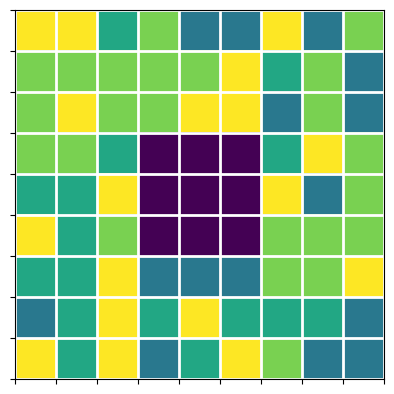

In [4]:
def generate_random_grid(key, k, mask):
    grid = jax.random.randint(key, (D_MAX, D_MAX), 1, k + 1)
    grid = jnp.where(mask == 0, grid, -1)
    return grid


key = jax.random.key(seed=3)

k = 4
# mask = jnp.array([
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
# ])
mask = jnp.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    dtype=jnp.int32,
)
grid = jax.jit(generate_random_grid)(key, k, mask)
print(grid[0])
plot_grid(grid, plt.gca(), vmin=-1, vmax=k)
plt.show()

In [5]:
ROLL_DIRECTIONS = [
    (-1, 0),  # roll up
    (1, 0),  # roll down
    (-1, 1),  # roll left
    (1, 1),  # roll right
]


def __translate_grid(grid, direction):
    def mask_vertical_fn(carry):
        grid, p = carry
        return grid.at[p, :].set(-1)

    def mask_horizontal_fn(carry):
        grid, p = carry
        return grid.at[:, p].set(-1)

    translated_grid = jnp.roll(grid, direction[0], axis=direction[1])

    p = jax.lax.cond(direction[0] == 1, lambda: 0, lambda: -1)
    grid = jax.lax.cond(
        direction[1] == 0,
        mask_vertical_fn,
        mask_horizontal_fn,
        (translated_grid, p),
    )
    return grid


def find_matches(grid):
    grid_roll_up = __translate_grid(grid, ROLL_DIRECTIONS[0])
    grid_roll_down = __translate_grid(grid, ROLL_DIRECTIONS[1])
    grid_roll_left = __translate_grid(grid, ROLL_DIRECTIONS[2])
    grid_roll_right = __translate_grid(grid, ROLL_DIRECTIONS[3])

    vertical_matches = jnp.equal(grid, grid_roll_up) & jnp.equal(grid, grid_roll_down)
    vertical_matches = jnp.logical_or(
        vertical_matches,
        jnp.logical_or(
            jnp.roll(vertical_matches, shift=-1, axis=0),
            jnp.roll(vertical_matches, shift=1, axis=0),
        ),
    )
    horizontal_matches = jnp.equal(grid, grid_roll_left) & jnp.equal(
        grid, grid_roll_right
    )
    horizontal_matches = jnp.logical_or(
        horizontal_matches,
        jnp.logical_or(
            jnp.roll(horizontal_matches, shift=-1, axis=1),
            jnp.roll(horizontal_matches, shift=1, axis=1),
        ),
    )
    # print(vertical_matches)

    all_matches = jnp.logical_or(vertical_matches, horizontal_matches)
    all_matches = jnp.where(grid == -1, False, all_matches)

    return all_matches

In [6]:
def generate_grid(key, num_symbols, mask=None):
    max_iter = 25
    if mask is None:
        mask = jnp.zeros((D_MAX, D_MAX))

    def cond_fn(carry):
        _, _, matches, i = carry
        return jnp.logical_and(jnp.sum(matches) > 0, i < max_iter)

    def body_fn(carry):
        key, grid, matches, i = carry
        key, subkey = jax.random.split(key)
        random_grid = generate_random_grid(subkey, num_symbols, mask)
        grid = jnp.where(matches, random_grid, grid)
        new_matches = find_matches(grid)
        return (key, grid, new_matches, i + 1)

    initial_grid = generate_random_grid(key, num_symbols, mask)
    initial_matches = find_matches(initial_grid)
    key, grid, matches, i = jax.lax.while_loop(
        cond_fn, body_fn, (key, initial_grid, initial_matches, 0)
    )
    return key, initial_grid, grid, matches, i

In [26]:
key = jax.random.key(seed=42)
key, initial_grid, grid, _, _ = jax.jit(generate_grid)(key, 4, mask)
print("GENERATED!")
grid_match = jnp.astype(find_matches(grid), int)
grid_match

GENERATED!


Array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

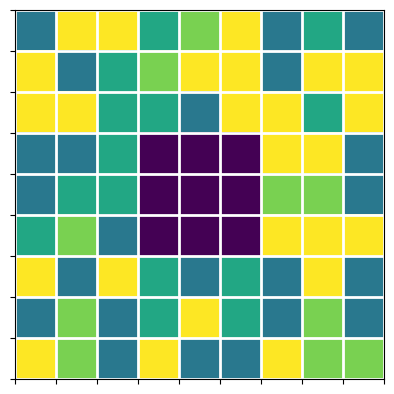

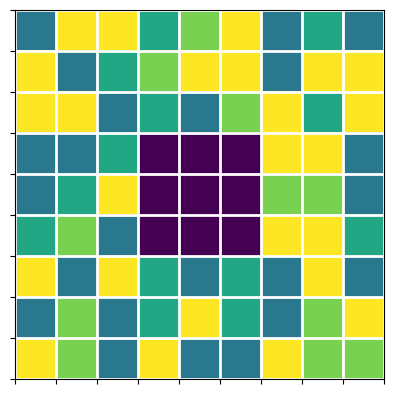

min_symbol -1
max_symbol 4


In [27]:
key, initial_grid, grid_no_matches, _, _ = jax.jit(generate_grid)(key, 4, mask)
plot_grid(initial_grid, plt.gca())
plt.show()
plot_grid(grid_no_matches, plt.gca())
plt.show()
# plot_grid(grid_match, plt.gca())

print("min_symbol", jnp.min(initial_grid))
print("max_symbol", jnp.max(initial_grid))

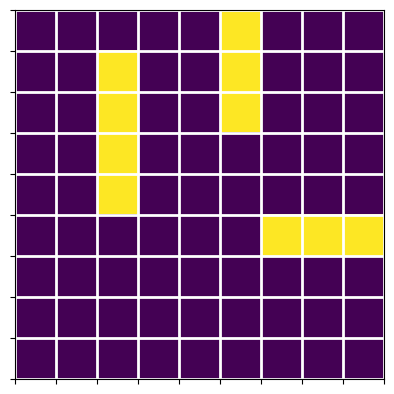

In [28]:
grid_match = jnp.astype(jax.jit(find_matches)(initial_grid), int)
plot_grid(grid_match, plt.gca())

In [29]:
def __translate_grid_vertical(grid, direction) -> chex.Array:
    # def mask_vertical_fn(carry):
    #     grid, p = carry
    #     return grid.at[p, :].set(-1)

    translated_grid = jnp.roll(grid, direction, axis=0)

    p = jax.lax.cond(direction == 1, lambda: 0, lambda: -1)
    grid = translated_grid.at[p, :].set(-1)  # mask_vertical_fn(translated_grid, p)

    return grid


def __translate_grid_horizontal(grid, direction) -> chex.Array:
    # def mask_horizontal_fn(carry):
    #     grid, p = carry
    #     return grid.at[:, p].set(-1)

    translated_grid = jnp.roll(grid, direction, axis=1)

    p = jax.lax.cond(direction == 1, lambda: 0, lambda: -1)
    grid = translated_grid.at[:, p].set(-1)  # mask_vertical_fn(translated_grid, p)

    return grid


def find_matches_2(grid: chex.Array) -> chex.Array:
    grid_roll_up = __translate_grid_vertical(grid, -1)
    grid_roll_down = __translate_grid_vertical(grid, 1)
    grid_roll_left = __translate_grid_horizontal(grid, -1)
    grid_roll_right = __translate_grid_horizontal(grid, 1)

    vertical_matches = jnp.equal(grid, grid_roll_up) & jnp.equal(grid, grid_roll_down)
    vertical_matches = jnp.logical_or(
        vertical_matches,
        jnp.logical_or(
            jnp.roll(vertical_matches, shift=-1, axis=0),
            jnp.roll(vertical_matches, shift=1, axis=0),
        ),
    )
    horizontal_matches = jnp.equal(grid, grid_roll_left) & jnp.equal(
        grid, grid_roll_right
    )
    horizontal_matches = jnp.logical_or(
        horizontal_matches,
        jnp.logical_or(
            jnp.roll(horizontal_matches, shift=-1, axis=1),
            jnp.roll(horizontal_matches, shift=1, axis=1),
        ),
    )
    # print(vertical_matches)

    all_matches = jnp.logical_or(vertical_matches, horizontal_matches)
    all_matches = jnp.where(grid == -1, False, all_matches)

    return all_matches

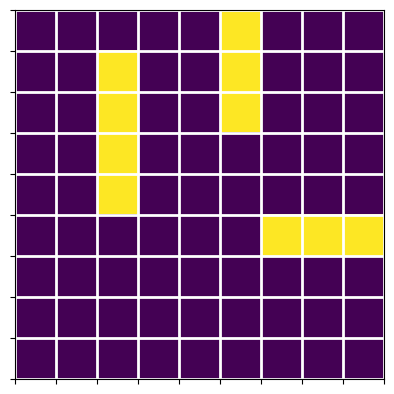

In [30]:
grid_match = jnp.astype(jax.jit(find_matches_2)(initial_grid), int)
plot_grid(grid_match, plt.gca())

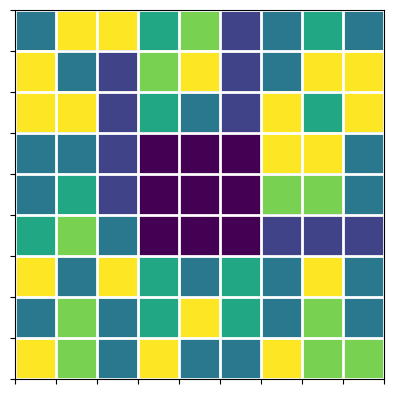

In [55]:
def remove_matches(grid):
    matches = find_matches(grid)
    grid = jnp.where(matches, 0, grid)
    return grid


# grid = generate_random_grid(jax.random.PRNGKey(1), (9,9), 4, mask)
grid = jax.jit(remove_matches)(initial_grid)
plot_grid(grid, plt.gca())

In [90]:
# @jax.jit
# def collapse_grid(grid):
#     def process_column(col_v):
#         col_i = jnp.arange(0, 9)
#         col_w = jnp.astype(col_v == -1, jnp.int4) - jnp.astype(col_v == 0, jnp.int4)

#         order = jnp.argsort(col_w, stable=True)
#         col_i = col_i[order]
#         col_v = col_v[order]

#         l_mask = col_v != -1
#         r_mask = col_v == -1

#         col_i = (
#             jnp.sort(col_i * l_mask + D_MAX * r_mask) * l_mask
#             + col_i * r_mask
#         )

#         order = jnp.argsort(col_i, stable=True)
#         return col_v[order]

#     # Vectorize over columns
#     processed_cols = jax.vmap(process_column)(grid.T)
#     return processed_cols.T


def collapse_grid(grid: chex.Array) -> chex.Array:
    def process_column(col_v: chex.Array) -> chex.Array:
        def cond_fn(carry):
            p_empty, p_symbol, _ = carry
            return jnp.logical_and(p_empty > 0, p_symbol > 0)

        def body_fn(carry):
            p_empty, p_symbol, col_v = carry
            # jax.debug.print(
            #     "p_empty: {p_empty}, p_symbol: {p_symbol}",
            #     p_empty=p_empty,
            #     p_symbol=p_symbol,
            # )
            # print(f"p_empty: {p_empty}, p_symbol: {p_symbol}")
            p_empty = jax.lax.cond(
                col_v.at[p_empty].get() == 0, lambda: p_empty, lambda: p_empty - 1
            )  # if cell is empty then wait
            p_symbol = jax.lax.cond(
                jnp.logical_and(p_symbol < p_empty, col_v.at[p_symbol].get() > 0),
                lambda: p_symbol,
                lambda: p_symbol - 1,
            )  # if cell is symbol and higher than empty cell then wait
            p_empty_val = col_v.at[p_empty].get()
            p_symbol_val = col_v.at[p_symbol].get()
            can_swap = jnp.logical_and(
                p_symbol < p_empty, jnp.logical_and(p_empty_val == 0, p_symbol_val > 0)
            )

            # jax.debug.print("can_swap: {can_swap}; p_empty: {p_empty}; p_symbol: {p_symbol}", can_swap=can_swap, p_empty=p_empty, p_symbol=p_symbol)

            col_v = jax.lax.cond(
                can_swap,
                lambda: col_v.at[p_empty]
                .set(p_symbol_val)
                .at[p_symbol]
                .set(p_empty_val),
                lambda: col_v,
            )
            return p_empty, p_symbol, col_v

        p_empty = D_MAX  # get the index of the first empty cell from the bottom
        p_symbol = D_MAX  # get the index of the first non-empty cell from the bottom

        _, _, col_v = jax.lax.while_loop(cond_fn, body_fn, (p_empty, p_symbol, col_v))
        return col_v

    processed_cols = jax.vmap(process_column)(grid.T)
    # col_v = process_column(grid.at[:, -1].get())
    # print(col_v)
    # processed_cols = grid.at[:, -1].set(col_v)
    return processed_cols.T

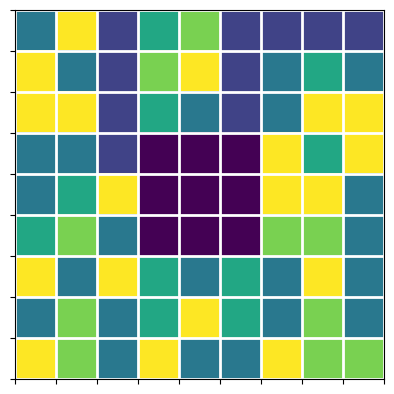

In [91]:
grid_collapsed = collapse_grid(grid)
# grid = jax.jit(collapse_grid)(grid)
plot_grid(grid_collapsed, plt.gca())

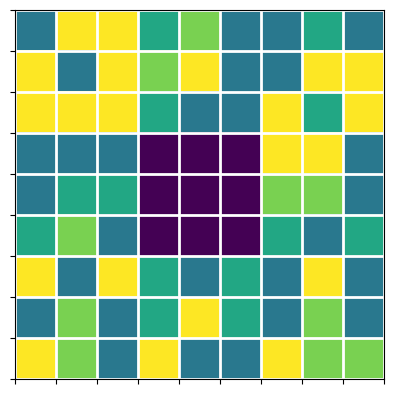

In [89]:
def refill_grid(key, grid, k, mask):
    key, subkey = jax.random.split(key)
    random_grid = generate_random_grid(subkey, k, mask)
    return jnp.where(grid == 0, random_grid, grid)


grid_new = jax.jit(refill_grid)(key, grid, 4, mask)
plot_grid(grid_new, plt.gca())

In [254]:
def __translate_row(grid, row_idx, direction):
    row_v = grid.at[row_idx, :].get()
    row_v = jnp.roll(row_v, direction)
    row_v = jax.lax.cond(
        direction > 0, lambda: row_v.at[0].set(-1), lambda: row_v.at[-1].set(-1)
    )
    return grid.at[row_idx, :].set(row_v)


def __translate_column(grid, col_idx, direction: int):
    col_v = grid.at[:, col_idx].get()
    col_v = jnp.roll(col_v, direction)
    col_v = jax.lax.cond(
        direction > 0, lambda: col_v.at[0].set(-1), lambda: col_v.at[-1].set(-1)
    )
    return grid.at[:, col_idx].set(col_v)


def __reapply_mask(grid, mask):
    return grid * jnp.logical_xor(grid, mask) - mask


def __get_translated_grids_tuple(grid, mask):
    grid_new_down = jax.vmap(__translate_column, in_axes=(None, 0, None))(
        grid, jnp.arange(D_MAX), -1
    )
    grid_new_up = jax.vmap(__translate_column, in_axes=(None, 0, None))(
        grid, jnp.arange(D_MAX), 1
    )
    grid_new_right = jax.vmap(__translate_row, in_axes=(None, 0, None))(
        grid, jnp.arange(D_MAX), -1
    )
    grid_new_left = jax.vmap(__translate_row, in_axes=(None, 0, None))(
        grid, jnp.arange(D_MAX), 1
    )

    # grid_new_down = __reapply_mask(grid_new_down, mask)
    # grid_new_up = __reapply_mask(grid_new_up, mask)
    # grid_new_right = __reapply_mask(grid_new_right, mask)
    # grid_new_left = __reapply_mask(grid_new_left, mask)

    return grid_new_down, grid_new_up, grid_new_right, grid_new_left

9it [00:00, 40.19it/s]


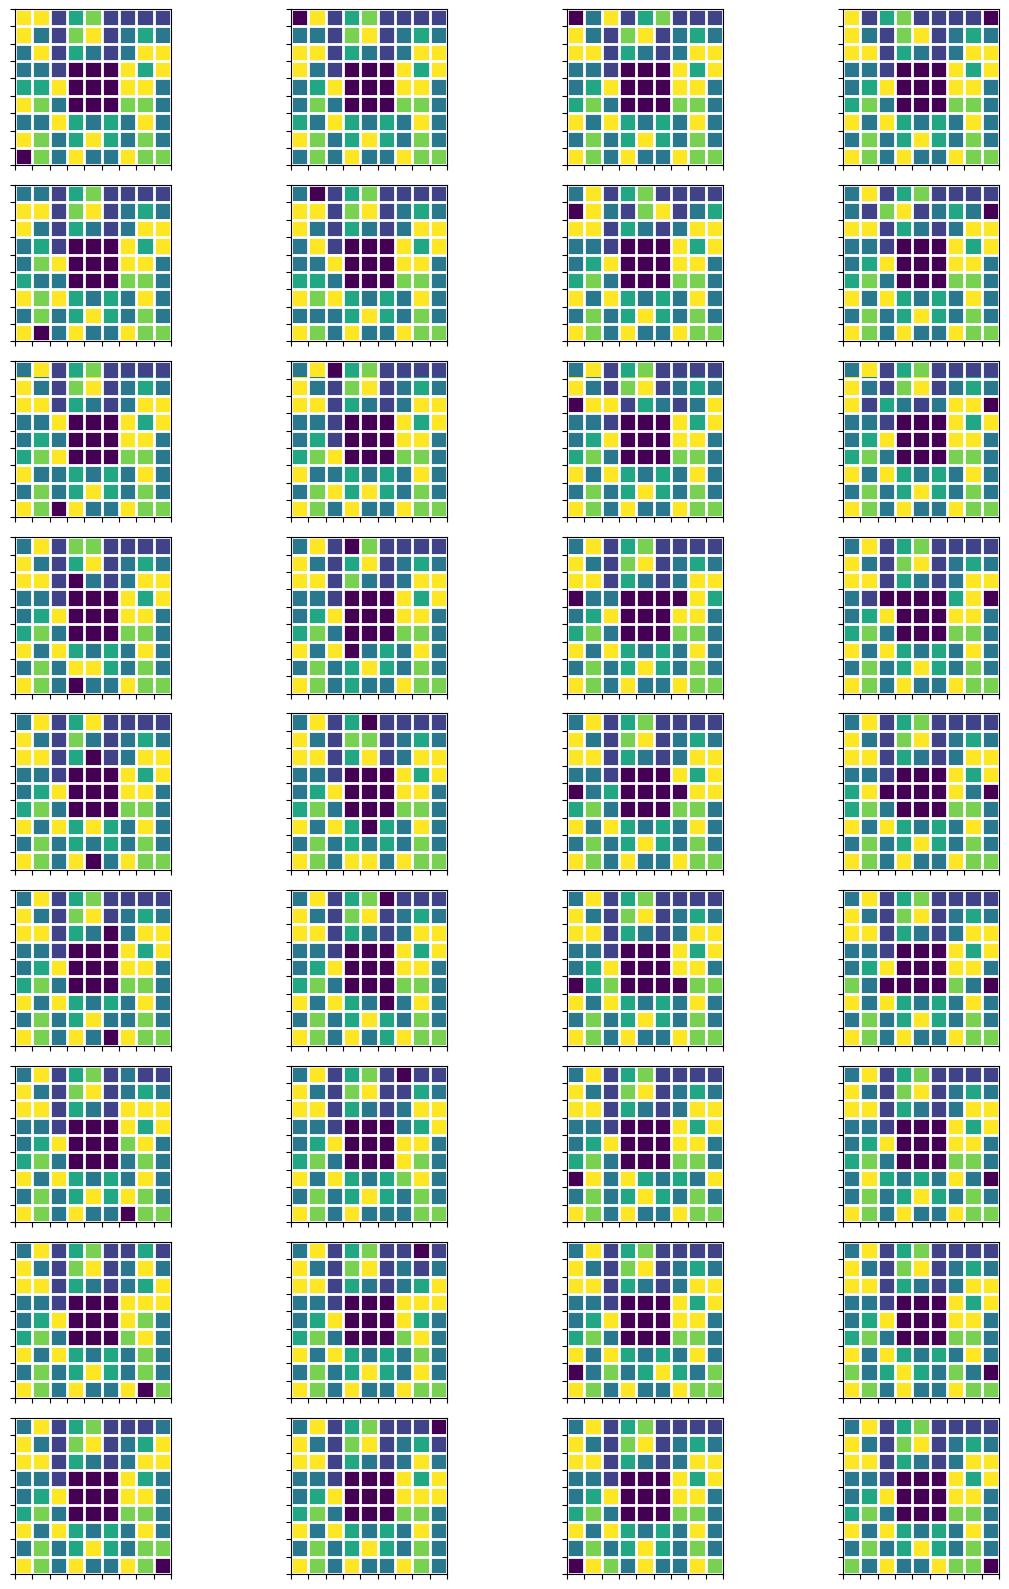

In [255]:
grid_new_down, grid_new_up, grid_new_right, grid_new_left = jax.jit(
    __get_translated_grids_tuple
)(grid, mask)

grids = jnp.concatenate(
    (grid_new_down, grid_new_up, grid_new_left, grid_new_right), axis=0
)
grids = jax.vmap(__reapply_mask, in_axes=(0, None))(grids, mask)

fig, axs = plt.subplots(D_MAX, 4, figsize=(12, 16))
for i, (ax0, ax1, ax2, ax3) in tqdm(enumerate(axs)):
    plot_grid(grids[0 + i], ax0, vmin=-1, vmax=4)
    plot_grid(grids[9 * 1 + i], ax1, vmin=-1, vmax=4)
    plot_grid(grids[9 * 2 + i], ax2, vmin=-1, vmax=4)
    plot_grid(grids[9 * 3 + i], ax3, vmin=-1, vmax=4)

plt.tight_layout()
plt.show()

In [256]:
def check_no_matches(grid, mask):
    grids = jnp.concatenate(__get_translated_grids_tuple(grid, mask), axis=0)
    matches = jax.vmap(find_matches)(grids)
    return jnp.all(jnp.sum(matches, axis=(1, 2)) == 0)

In [257]:
jax.jit(check_no_matches)(grid_no_matches, mask)

Array(False, dtype=bool)

In [258]:
def generate_new_grid_if_no_matches(key, grid, k, mask):
    return jax.lax.cond(
        check_no_matches(grid, mask),
        lambda: generate_grid(key, grid.shape, k, mask),
        lambda: grid,
    )